<img style="float: left;" src="resources/made.jpg" width="25%" height="25%">

# Академия MADE
## Семинар 5: PyTorch Lightning и подбор гиперпараметров
Иван Карпухин

<div style="clear:both;"></div>

План:
* Обучение моделей при помощи PyTorch Lightning
* Подбор гиперпараметров при помощи Optuna

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* pytorch_lightning
* optuna

Установить их можно командой:
```bash
pip3 install --user torch torchvision optuna opencv-python pytorch_lightning
```

In [ ]:
# COLAB USERS
# !pip3 install optuna pytorch_lightning
# !wget https://raw.githubusercontent.com/lysukhin/MADE/2022/basic_dl/seminar05_lightning-optuna/seminar.py

In [4]:
# !pip install torchvision==0.9.0

  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1
    Uninstalling torchvision-0.11.1:
      Successfully uninstalled torchvision-0.11.1


In [1]:
import numpy as np
import optuna
import pytorch_lightning as pl
import torch
import torchvision

from matplotlib import pyplot as plt

from seminar import make_grid

USE_CUDA = torch.cuda.is_available()
CUDA_DEVICES = [0]

BATCHSIZE = 64
EPOCHS = 5

DATA_ROOT = "data"
TRAIN_ROOT = "train"

print("PyTorch version: {}".format(torch.__version__))
print("Lightning version: {}".format(pl.__version__))
print("Use CUDA: {}".format(USE_CUDA))

PyTorch version: 1.12.1+cpu
Lightning version: 1.4.9
Use CUDA: False


### Типичный ML pipeline.

<img src="resources/bicycle.jpg" width="35%" height="35%" align="left">
<div style="clear:both;"></div>

Большое количество кода повторяется от проекта к проекту:
* Тренировочный цикл
* Управление чекпоинтами
* Работа с GPU и распределённая тренировка

Типичные пайплайны уже реализованы в высокоуровневых библиотеках:
* TensorFlow Estimator
* PyTorch Ignite
* PyTorch Lightning
* Catalyst

См. сравнение Ignite vs Lightning:

https://towardsdatascience.com/pytorch-lightning-vs-pytorch-ignite-vs-fast-ai-61dc7480ad8a

### Pytorch Lightning

<img src="resources/lightning.png" align="left">
<div style="clear:both;"></div>

# Тренировка с Pytorch Lightning

Создадим три базовых класса: LightningDataModule, LightningModule, Trainer.

### LightningDataModule

* Хранит информацию о Train/Dev/Test корпусах
* Создаёт DataLoader-ы

Если нужно несколько корупсов:

https://pytorch-lightning.readthedocs.io/en/stable/multiple_loaders.html

Files already downloaded and verified
Files already downloaded and verified
train size: 50000


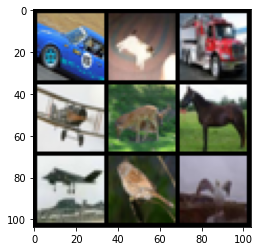

dev size: 5000


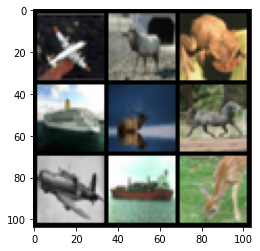

test size: 5000


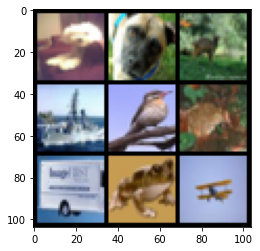

In [2]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""
    
    def __init__(self, data_root, batch_size):
        super().__init__()
        self._data_root = data_root
        
        self._labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", 
                        "frog", "horse", "ship", "truck"]
        
        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": batch_size,
            "num_workers": 1  # Prepare data in parallel.
        }
        
    @property
    def num_classes(self):
        return len(self._labels)
    
    @property
    def labels(self):
        return self._labels
    
    # Переопределяем метод базового класса, чтобы скачать данные.
    def prepare_data(self):
        torchvision.datasets.CIFAR10(self._data_root, train=True, download=True)
        torchvision.datasets.CIFAR10(self._data_root, train=False, download=True)
    
    # Переопределяем метод базового класса, чтобы подготовить данные.
    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root, train=True, transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root, train=False, transform=transform)
        
        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    # Переопределяем методы создания загрузчиков.
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"], **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"], **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"], **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()

        
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
data.prepare_data()
data.setup()
for tag in ["train", "dev", "test"]:
    data.show(tag)

### LightningModule

Объединяет:
* Модель
* Loss
* Оптимизатор

In [3]:
class Module(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self._model = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
    
    # Переопределеям метод базового класса, чтобы создать опитимизатор.
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)
    
    # Переопределяем метод обработки батча тренировочных данных.
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        self.log("TrainLoss", loss)
        return loss

### Trainer

Реализует пайплайн обучения. Наследовать не нужно.

In [4]:
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes)

trainer = pl.Trainer(
    default_root_dir=TRAIN_ROOT,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)
trainer.fit(module, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\asus\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
C:\Users\asus\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [5]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir ./train

Reusing TensorBoard on port 6006 (pid 19180), started 0:32:34 ago. (Use '!kill 19180' to kill it.)

Using in colab:
!zip -r train.zip train
from google.colab import files
files.download("train.zip")

Запустить tensorboard server:
```bash
tensorboard --logdir ./train
```

По умолчанию сервер запустится на 6006 порту.

<img src="resources/board-1-simple.png" align="left">
<div style="clear:both;"></div>

### Вопросы

# Extra logs

* Добавим логгирование Dev loss.
* Tensorboard обновляется каждые 2 минуты. Уменьшим до 10 секунд.
* Логируется каждый 50-й батч. Увеличим до 100.
* Добавим в Tensorboard изображения с предсказаниями.

In [7]:
class Module(pl.LightningModule):
    def __init__(self, num_classes, labels):
        super().__init__()
        self._labels = labels
        self._model = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
        
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:  # NEW.
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:  # NEW.
            # Show predicted images.
            self._plot(batch)
        return loss
    
    # NEW CODE BELOW. 
    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)
    
    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)
    
    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)
    
    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)
    
    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss
    
    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)
        
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes, labels=data.labels)

# Train dir will have the following structure:
# root
#   - experiment
#      - version
#         - checkpoints
#         - <logs>

logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="extra_logs",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)

trainer.fit(module, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


C:\Users\asus\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


<img src="resources/board-2-plot.png" align="left">
<div style="clear:both;"></div>

In [10]:
test.fit()

NameError: name 'test' is not defined

### More options
* Train using 2 GPUs
* Train in FP16

In [ ]:
logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="fp16",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=[0, 1],
    distributed_backend="dp",  # "ddp" better, but doesn't work with Jupyter.
    precision=16,
    max_epochs=EPOCHS
)

trainer.fit(module, data)
trainer.test()

<img src="resources/gpu-usage.png" align="left">
<div style="clear:both;"></div>

<img src="resources/board-3-fp16.png" align="left">
<div style="clear:both;"></div>

# Подбор гиперпараметров при помощи Optuna

In [ ]:
loss = lambda x, y: (x - 0.5) ** 2 + y * 0.01 + 5

xs = np.linspace(-1, 2, 100)
plt.plot(xs, loss(xs, xs * 0))
plt.show()

In [ ]:
def experiment(trial):
    x = trial.suggest_float("x", -10, 10)
    y = trial.suggest_float("y", -10, 10)
    return loss(x, y)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(experiment, n_trials=50, n_jobs=5)

optuna.logging.set_verbosity(optuna.logging.INFO)

print("Value:", study.best_value)
print("Parameters:", study.best_params)
print("Importance:", optuna.importance.get_param_importances(study))

Вопросы

# Подбор параметров обучения реальной сети

### Конфигурируемый Optimizer

In [ ]:
from collections import OrderedDict

class AdamOptimizer(torch.optim.Adam):
    def __init__(self, params, config):
        super().__init__(params,
                         lr=config["lr"],
                         weight_decay=config["weight_decay"],
                         amsgrad=config["amsgrad"])


class SGDOptimizer(torch.optim.SGD):
    def __init__(self, params, config):
        super().__init__(params,
                         lr=config["lr"],
                         momentum=config["momentum"],
                         weight_decay=config["weight_decay"],
                         nesterov=config["nesterov"])


class Optimizer(torch.optim.Optimizer):
    OPTIMIZERS = {
        "adam": AdamOptimizer,
        "sgd": SGDOptimizer
    }

    def __init__(self, params, config):
        # No super().__init__. Inheritance is only for PyTorch Lightning checks.
        self._config = config
        self._optimizer = self.OPTIMIZERS[self._config["optimizer"]](params, self._config["optimizer_params"])

    def step(self, closure=None):
        kwargs = {}
        if closure is not None:
            kwargs["closure"] = closure
        self._optimizer.step(**kwargs)

    def zero_grad(self):
        self._optimizer.zero_grad()

    def state_dict(self):
        return self._optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self._optimizer.load_state_dict(state_dict)

    @property
    def param_groups(self):
        return self._optimizer.param_groups

    @property
    def state(self):
        return self._optimizer.state

### Конфигурируемый DataModule

In [ ]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""
    
    def __init__(self, data_root, config):
        super().__init__()
        self._data_root = data_root
        
        self._labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        
        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": config["batch_size"],
            "num_workers": 1  # Prepare data in parallel.
        }
        
    @property
    def num_classes(self):
        return len(self._labels)
    
    @property
    def labels(self):
        return self._labels
    
    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root, train=True, download=True, transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root, train=False, download=True, transform=transform)
        
        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"], **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"], **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"], **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()

### Конфигурируемый Module

In [ ]:
class Module(pl.LightningModule):
    MODELS = {
        "resnet18": torchvision.models.resnet18,
        "resnet34": torchvision.models.resnet34
    }
    
    def __init__(self, num_classes, labels, config):
        super().__init__()
        self._config = config
        self._labels = labels
        self._model = self.MODELS[self._config["model"]](num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
        
    def configure_optimizers(self):
        return Optimizer(self._model.parameters(), config=self._config["optimizer_params"])
    
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:
            self._plot(batch)
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)
    
    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)
        # Return validation loss for early stopping.
        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)
    
    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)
    
    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss
    
    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)

### Объединим в одну систему

In [ ]:
class Experiment:
    def __init__(self, train_root):
        self._train_root = train_root
        
    def __call__(self, trial):
        config = {
            "seed": trial.suggest_int("seed", 0, 10),
            "data_params": {
                "batch_size": trial.suggest_int("data_params.batch_size", 64, 512, 64)
            },
            "module_params": {
                "model": trial.suggest_categorical("module_params.model", ["resnet18", "resnet34"]),
                "optimizer_params": {
                    "optimizer": trial.suggest_categorical("module_params.optimizer_params.optimizer", ["adam", "sgd"]),
                    "optimizer_params": {
                        "lr": trial.suggest_float("module_params.optimizer_params.optimizer_params.lr",
                                                  1e-5, 1e-2, log=True),
                        "amsgrad": trial.suggest_categorical("module_params.optimizer_params.optimizer_params.amsgrad",
                                                  [True, False]),
                        "nesterov": trial.suggest_categorical("module_params.optimizer_params.optimizer_params.nesterov",
                                                  [True, False]),
                        "weight_decay": trial.suggest_float("module_params.optimizer_params.optimizer_params.weight_decay",
                                                  0, 1e-4),
                        "momentum": trial.suggest_float("module_params.optimizer_params.optimizer_params.momentum",
                                                  0, 1)
                    }
                }
            }
        }
            
        torch.manual_seed(config["seed"])
        np.random.seed(config["seed"])

        data = DataModule(DATA_ROOT, config=config["data_params"])
        module = Module(data.num_classes, data.labels,
                        config=config["module_params"])

        logger = pl.loggers.TensorBoardLogger(
            save_dir=self._train_root,  # Root for all experiments.
            name="hyper",  # Experiment name, same as subdirectory name.
            flush_secs=10  # Update TensorBoard every 10 seconds.
        )

        trainer = pl.Trainer(
            logger=logger,
            gpus=1 if USE_CUDA else 0,
            max_epochs=EPOCHS,

            # Optuna callback for early stopping.
            callbacks=[optuna.integration.PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        )

        trainer.fit(module, data)
        return trainer.callback_metrics["val_loss"].item()
        
import os
os.makedirs(TRAIN_ROOT, exist_ok=True)
study = optuna.create_study("sqlite:///{}/study.db".format(TRAIN_ROOT))

study.optimize(Experiment(TRAIN_ROOT), n_trials=100)
result = {
    "value": study.best_value,
    "params": study.best_params,
    "importance": optuna.importance.get_param_importances(study)
}

import json
with open(os.path.join(TRAIN_ROOT, "result.json"), "w") as fp:
    json.dump(result, fp)

print(result)

<img src="resources/board-4-hyper.png" align="left">
<div style="clear:both;"></div>

In [ ]:
print("Best parameters:")
print("")
for k, v in result["params"].items():
    print(k)
    print("    ", v)

In [ ]:
print("Importance:")
print("")
for k, v in result["importance"].items():
    print("{:.3f}".format(v), k)

In [ ]:
import os
from seminar import show_study

show_study(os.path.join(TRAIN_ROOT, "study.db"))

Что дальше:
* Сделайте параметр "pretrained" модели конфигурируемым и запустите подбор гиперпараметров.
* Попорбуйте сделать параметрические FC и Conv слои, подобрать параметры (например, размер свёртки) на CIFAR10,
* Стандартный pruner из Optuna останавливает тренировку экспериментов, если на первых итерациях модель остаёт от медианы. Попробуйте улучшить качество, подобрав pruner и параметры.